# 1. Global methane levels from 2002

For this problem set, methane levels have been determined by applying several algorithms to different satellite instruments. Download the netCDF4 file (200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc) here, which contains monthly-averaged methane levels (xch4) in the unit of ppb at each 5° (lon) x 5° (lat) grid over the globe from 2003-01 to 2020-06.

In [1]:
import netCDF4
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings("ignore")     #忽略warnings
ds = xr.open_dataset("200301_202006-C3S-L3_GHG-PRODUCTS-OBS4MIPS-MERGED-v4.3.nc", engine="netcdf4")
ds

<xarray.Dataset>
Dimensions:                  (time: 210, bnds: 2, lat: 36, lon: 72, pressure: 10)
Coordinates:
  * time                     (time) datetime64[ns] 2003-01-16T12:00:00 ... 20...
  * lat                      (lat) float64 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * lon                      (lon) float64 -177.5 -172.5 -167.5 ... 172.5 177.5
Dimensions without coordinates: bnds, pressure
Data variables:
    time_bnds                (time, bnds) datetime64[ns] ...
    lat_bnds                 (lat, bnds) float64 ...
    lon_bnds                 (lon, bnds) float64 ...
    pre                      (pressure) float64 ...
    pre_bnds                 (pressure, bnds) float64 ...
    land_fraction            (lat, lon) float64 ...
    xch4                     (time, lat, lon) float32 ...
    xch4_nobs                (time, lat, lon) float64 ...
    xch4_stderr              (time, lat, lon) float32 ...
    xch4_stddev              (time, lat, lon) float32 ...
    column_averaging_kernel  (time, pressure, lat, lon) float32 ...
    vmr_profile_ch4_apriori  (time, pressure, lat, lon) float32 ...
Attributes: (12/28)
    activity_id:            obs4MIPs
    comment:                Since long time, climate modellers use ensemble a...
    contact:                Maximilian Reuter (maximilian.reuter@iup.physik.u...
    Conventions:            CF-1.7 ODS-2.1
    creation_date:          2021-02-05T09:48:47Z
    data_specs_version:     2.1.0
    ...                     ...
    source_version_number:  v4.3
    title:                  C3S XCH4 v4.3
    tracking_id:            892d184a-7b35-4bba-836a-94b9cfeb360e
    variable_id:            xch4
    variant_info:           Best Estimate
    variant_label:          BE

#### 1.1 [5 points] Compute methane climatology for each month, and plot your results in 12 panels.

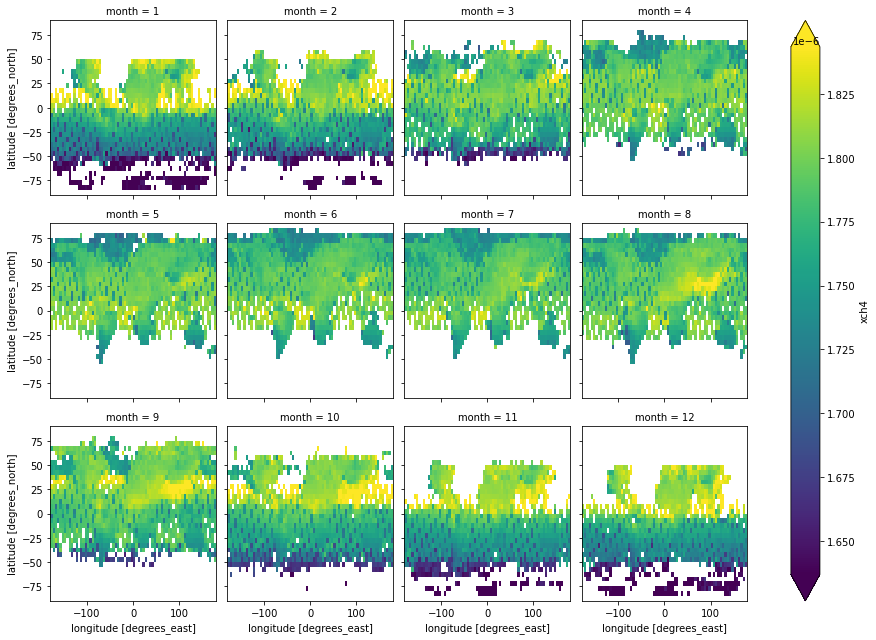

In [31]:
mc = ds.xch4
q1_1 = mc.groupby(mc.time.dt.month).mean()
q1_1.plot(col="month",   #Draw the image according to the categories of the month
          col_wrap=4,
          robust=True)  #'robust = True' to eliminate outliers
plt.show()

#### 1.2 [5 points] Plot globally-averaged methane from 2003-01 to 2020-06 as a time series. Describe your results. Check your plot with this one.

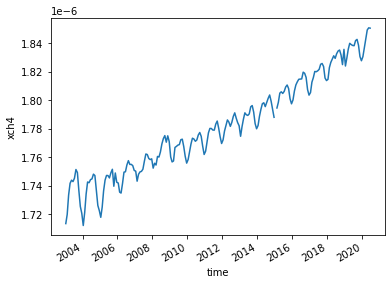

In [30]:
weight = np.cos(np.deg2rad(mc.lat))
mc.weighted(weight).mean(dim=('lat','lon'),skipna=True).plot()
plt.show()

A: Globally-averaged methane climatology goes up over time, and has a distinct seasonal periodicity

#### 1.3 [5 points] Plot deseasonalized methane levels at point [15°S, 150°W] from 2003-01 to 2020-06 as a time series. Describe your results.

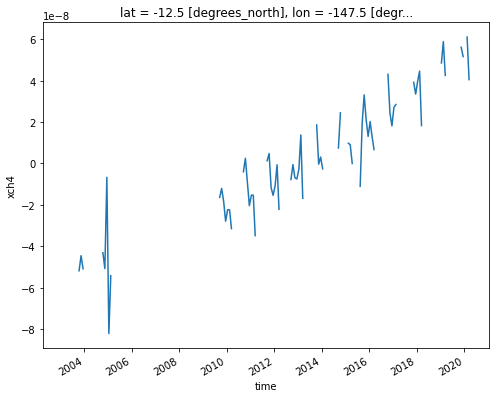

In [29]:
groupdata = mc.groupby('time.month')
mc_anom = groupdata - groupdata.mean(dim='time')
mc_anom.sel(lon=-150, lat=-15,method='nearest').plot(figsize=(8, 6))
plt.show()

A：There will be many NANs near the point [15°S, 150°W], resulting in an incomplete graph

#### 2.1 [10 points] Compute monthly climatology for SST from Niño 3.4 region, and subtract climatology from SST time series to obtain anomalies.

In [5]:
da = xr.open_dataset("NOAA_NCDC_ERSST_v3b_SST.nc", engine="netcdf4")
weights = np.cos(np.deg2rad(da.lat))
sst_mean = da.sst.sel(lat=slice(-5,5),                                             
                      lon=slice(-170+360,-120+360)).weighted(weights).mean(dim=('lon','lat'))  #Weighted average
monthly_sst = sst_mean.groupby('time.month').mean()
anom = sst_mean.groupby("time.month")-monthly_sst # Apply mean to grouped data, and then compute the anomaly 
anom_3 = anom.rolling(time = 3).mean()     # Show rolling means
mean_3_anomalies = anom_3.isel(time=slice(2, 684))   #Removing NAN
df = pd.DataFrame(mean_3_anomalies,columns=['mean_3_anomalies'])
df['date'] = pd.DataFrame(mean_3_anomalies.time)
df

,mean_3_anomalies,date
0,-0.352137,1960-03-15
1,-0.307922,1960-04-15
2,-0.210945,1960-05-15
3,-0.240803,1960-06-15
4,-0.225803,1960-07-15
...,...,...
677,-0.442696,2016-08-15
678,-0.618628,2016-09-15
679,-0.728378,2016-10-15
680,-0.836065,2016-11-15


#### 2.2 [10 points] Visualize the computed Niño 3.4. Your plot should look similar to this one.

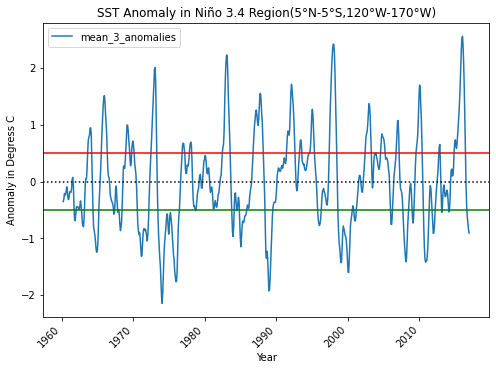

In [6]:
df.plot(x="date",y="mean_3_anomalies",figsize=(8, 6))
plt.axhline(y=0.5,ls="-",c="r")  #Mark the line corresponding to the outlier
plt.axhline(y=0,ls=":",c="black")  
plt.axhline(y=-0.5,ls="-",c="g")  #Mark the line corresponding to the outlier
plt.xticks(rotation=45)     #The X-axis is marked by a 45° rotation
plt.ylabel('Anomaly in Degress C')
plt.xlabel('Year')
plt.title('SST Anomaly in Niño 3.4 Region(5°N-5°S,120°W-170°W)')
plt.show()

# 3. Explore a netCDF dataset

#### 3.1 [5 points] Plot a time series of a certain variable with monthly seasonal cycle removed.

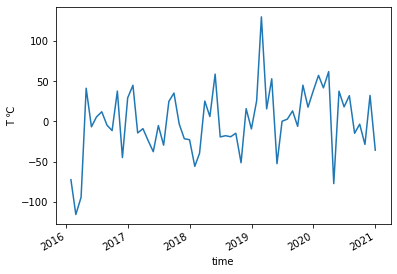

In [9]:
T = xr.open_dataset('2016-2020-T.nc',engine="netcdf4")
group_data = T.t2m.groupby('time.month')
T_anom = group_data - group_data.mean(dim='time') # Apply mean to grouped data, and then compute the anomaly 
T_anom_d = T_anom.sum(dim=('latitude','longitude'))  
T_anom_m = T_anom_d.resample(time='M').mean().plot()
plt.ylabel('T ℃')
plt.show()    #The original graph of the data is in 3.2

#### 3.2 [10 points] Make at least 5 different plots using the dataset.

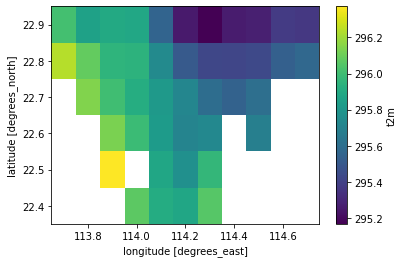

In [10]:
T.t2m.mean(dim='time').plot()
plt.show()

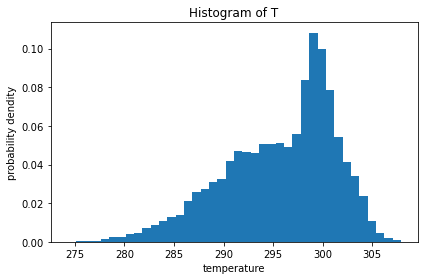

In [15]:
q3_2=T.t2m.mean(dim=('longitude','latitude'))   #Global data average
fig, ax = plt.subplots()
n, bins, patches = ax.hist(q3_2,40, density=1)# the histogram of the data
plt.title('Histogram of T')
plt.xlabel('temperature')
plt.ylabel('probability dendity')
plt.tight_layout()  #Automatically adjusts subgraph parameters to provide the specified population
plt.show()

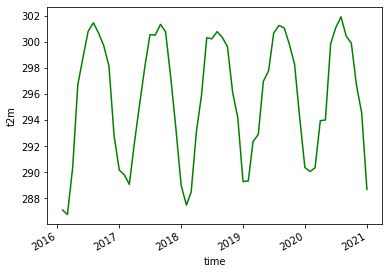

In [26]:
monthly_mean = q3_2.resample(time='M').mean()
monthly_mean.plot(color='g')
plt.show()

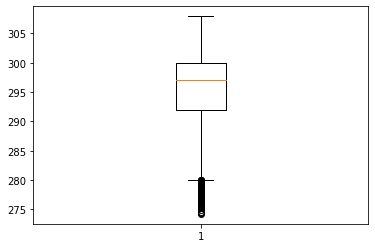

In [18]:
plt.boxplot(q3_2)
plt.show()

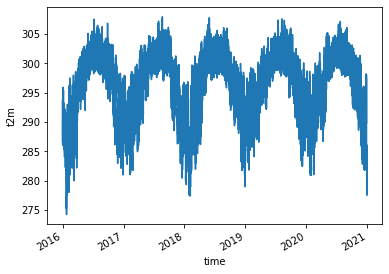

In [28]:
q3_2.plot()   #The original data graph shows seasonal periodicity
plt.show()